# Coincidence of want optimization using Julia

In this series, we will demonstrate the capabilities of our decentralized exchange (DEX) path optimization framework `DEXTra.jl`.
`DEXTra` is a Julia package that considers all aspects of optimizing the transfer of funds across DEXs.
A detailed description of the other capabilities will be presented in future posts.

Coincidence of wants (CoW) is the economic phenomenon were two or more parties each hold something that the others directly desires so they can exchange in order to "_maximized the cumulative utility_" as an economist would say.
While this type of direct bartering is not required in traditional finance due to a common, effectively infinite reference currency --- the US dollar, the idea of CoW is crucial for an efficient crypto ecosystem.
The reason arises from the fact that transaction on DEXs incur costs at every step in the form of operation fees and slippage (the algorithmically determined cost to minimize the impact on the exchanges liquidity).
Of course these costs are necessary to keep provide the service and liquidity required to trade assets back and forth.
However, when we do have a the following situation:


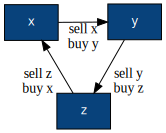

In [30]:
using GraphViz
dot"""
 digraph{
    splines=true;
    sep="+25,25";
    overlap=scalexy;
    nodesep=0.6;
    node [shape=rect style=filled fontcolor=white fontsize=12 fontname="Helvetica Bold" fillcolor="#08427b"];
    x -> y [ label="sell x\nbuy y" ];
    y -> z [ label="sell y\nbuy z" ];
    z -> x [ label="sell z\nbuy x" ];
 }
"""

it is always advantageous to first pair up the users and send the remainder through the DEXs to minimized the slippage.

This is the strategy employ by exchanges such as _CoW Swap_, and should be a requirement for a for all modern DEX applications.
In this post, we will demonstrate:

- How orders and orders and orderbooks are represented in our Julia framework.
- How we can optimizer the execution of orders in an orderbook to provide the maximum value to users.
- How the performance of our solution scales with system size.

Through these applications we will also see the mathematical justifications for concepts like stable coins and operator-imposed price ranges for assets.

# Definition of orders and orderbooks

DEXTra used the tuple representing orders in an orderbook [[T. Walther _et al._](https://link.springer.com/chapter/10.1007/978-3-030-18500-8_29)], which will be presented in brief here to aid the rest of our discussions.
Let's consider a tradeable ordered list of some asset for example `["DAI", "ETH", "BTC"]`, each order in the orderbook can be be presented as a tuple

$$ \omega_i= (\beta,\sigma, \bar{x},\bar{y},\pi),$$

where: 

1. $\beta$ is the BUY asset index --- ex. `3` for `"BTC"`.
2. $\sigma$ is the SELL asset --- ex. `1` for `"DAI"`.
3. $\bar{x}$ (resp. $\bar{y}$) are the maximum buy (resp. sell) amount of each asset and 
4. $\pi$ is the maximum exchange rate willing to pay for the pair $\alpha_j$ for $\alpha_k$, i.e., $\frac{p_j}{p_k}\leq \pi$. 

It's important to note here that the price is a free variable and is something that needs to be solved for by the optimization framework.

By writing orders in this form, we are able to express several types of orders, such as: 

1. _Limit buy orders ($\beta$, $\sigma$, $\bar{x}$,$+\infty$, $\pi$)_ (with $\bar{x},\pi<+\infty$):
"Buy (at most) $x$ units of token $\beta$ for $\sigma$ if the exchange rate $p_j/p_k$
is at most $\pi$".
2. _Limit sell orders  ($\beta$, $\sigma$,$+\infty$,$\bar{y}$,  $\pi$)_   with $\bar{y},\pi<+\infty$:
"Sell (at most) $y$ units of token $\sigma$ for $\sigma$ if the exchange rate $p_k/p_j$
is at least $1/\pi$". 

4. _Market buy orders as ($\beta$, $\sigma$,$\bar{x}$ , $+\infty$,$+\infty$)_ with $\bar{x}<+\infty$:
"Buy (at most) $\bar{x}$ units of token $\beta$ for $\sigma$ at market rate".

4. _Market sell orders as ($\beta$, $\sigma$, $+\infty$,$\bar{y}$, $+\infty$)_ with $\bar{y}<+\infty$: 
"Sell (at most) y units of token token $\beta$ for $\sigma$ at market rate".

In [10]:
using Revise

In [7]:
# Load the package
using DEXTra, JuMP

┌ Info: Precompiling DEXTra [88458aad-b251-4a2a-9734-84f27610c482]
└ @ Base loading.jl:1342


The DEXTra framework provides a simple interface for constructing the different types of orders and stores them in an `Order` object. 

In [8]:
@doc LimitBuyOrder

```
LimitBuyOrder
```

A tuple representing a limit buy order in the orderbook.

**Fields**

  * `β`: The index of the asset being bought.
  * `σ`: The index of the asset being sold.
  * `x̄`: The maximum buy amount.
  * `π`: The maximum exchange rate (i.e. price[β]/price[σ] ≤ π).


In [9]:
LimitBuyOrder(2, 1, 6, 7.5E-4) |> typeof

Order

A list of many `Order` objects can be combined together form and `OrderBook` which is useful for keeping the ordered list of assets in the same place.
Here, we combine the desired trades in the order book into a graph that represents the desired flow of assets in the orderbook.
The edge color and values shown are the cumulative value that of trades between two assets.

Note that since the price is a optimization variable, we can only assign value to the edges if we use an external estimate of the prices.

In [5]:
?LimitBuyOrder

search:

Couldn't find LimitBuyOrder
Perhaps you meant PipeBuffer


No documentation found.

Binding `LimitBuyOrder` does not exist.


vvec = [1328.0, 664.0]


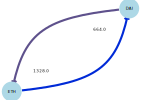

In [36]:
o1 = LimitBuyOrder(2, 1, 1, 1329.0) 
o2 = LimitSellOrder(1, 2, 0.5, 0.00075)
orderbook = OrderBook([o1, o2], ["DAI", "ETH"])
approx_prices = [1.0, 1328.0]
get_graph(
    orderbook, 
    approx_prices; 
    min_val=1000, 
    max_val=2000,
)


In [20]:
model, x, y, p = construct_model(total_trade_volume, orderbook)
optimize!(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       12
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999960e-04 5.00e-03 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [21]:
latex_formulation(model)

$$ \begin{aligned}
\max\quad & x_{1}\times p_{2} + x_{2}\times p_{1}\\
\text{Subject to} \quad & x_{1} - y_{2} = 0.0\\
 & x_{2} - y_{1} = 0.0\\
 & -1329 p_{1} + p_{2} \leq 0.0\\
 & p_{2}\times x_{1} - y_{1}\times p_{1} = 0.0\\
 & p_{1}\times x_{2} - y_{2}\times p_{2} = 0.0\\
 & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & y_{1} \geq 0.0\\
 & y_{2} \geq 0.0\\
 & p_{1} \geq 0.0\\
 & p_{2} \geq 0.0\\
 & x_{1} \leq 1.0\\
 & y_{2} \leq 0.5\\
\end{aligned} $$

In [24]:
summarize(orderbook, x, y ,p)

Order: Order(2, 1, 1.0, Inf, 1329.0)
Executed: BUY: 0.4437835808703281 (out of 1.0) at price 0.2491866475549786
Executed: SELL: 2.9219720524150126 (out of Inf) at price 0.03784599605106498
Order: Order(1, 2, Inf, 0.5, Inf)
Executed: BUY: 2.9219720524150126 (out of Inf) at price 0.03784599605106498
Executed: SELL: 0.4437835808703281 (out of 0.5) at price 0.2491866475549786


In [32]:
model, x, y, p = construct_model(total_trade_volume, orderbook)
@constraint(model, p[1] == 1)
optimize!(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999960e-04 9.90e-01 5.05e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [33]:
summarize(orderbook, x, y ,p)

Order: Order(2, 1, 1.0, Inf, 1329.0)
Executed: BUY: 0.4999999902282672 (out of 1.0) at price 0.06233554083549539
Executed: SELL: 0.031167769808621442 (out of Inf) at price 1.0
Order: Order(1, 2, Inf, 0.5, Inf)
Executed: BUY: 0.031167769808621442 (out of Inf) at price 1.0
Executed: SELL: 0.4999999902282672 (out of 0.5) at price 0.06233554083549539


In [34]:
exec_prices = value.(p)


2-element Vector{Float64}:
 1.0
 0.06233554083549539

In [50]:
exec_prices = value.(p)
for (o, xv, yv) in zip(orderbook.orders, value.(x), value.(y))
    @show o, xv, yv
end


(o, xv, yv) = (Order(2, 1, 1.0, Inf, 1329.0), 0.4974436131158717, 661.1025618333132)
(o, xv, yv) = (Order(1, 2, Inf, 0.5, 0.00075), 661.1025618333132, 0.4974436131158717)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       10
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        4
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999960e-04 9.90e-01 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [12]:
exec_prices = value.(p)

for (o, xv, yv) in zip(orderbook.orders, value.(x), value.(y))
    @show o, xv, yv
end

(o, xv, yv) = (Order(2, 1, 1.0, Inf, 1329.0, true), 1.0000000099981143, 1329.000013294988)
(o, xv, yv) = (Order(2, 1, Inf, 300.0, 1328.0, false), 0.22573363656569026, 300.00000299749405)


vvec = [7968.0, 3880.0, 1000.0]


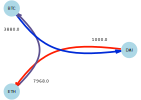

In [132]:
o1 = LimitBuyOrder(2, 1, 6, 1329.0) 
o2 = LimitSellOrder(2, 3, 0.2, 0.07)
o3 = LimitBuyOrder(1, 3, 1000, 0.003)
# o4 = LimitBuyOrder(1, 3, 2000, 0.003)
orderbook = OrderBook([o1, o2, o3], ["DAI", "ETH", "BTC"])
approx_prices = [1.0, 1328.0, 19400.0]
get_graph(orderbook, approx_prices; min_val=2000, max_val=8000)


In [144]:
pval = value.(p)
pval[1] - 0.003 * pval[3]

-7.218988943279614e11

In [142]:
model, x, y, p = construct_model(total_trade_volume, orderbook)
@constraint(model, p[1] == 1)
latex_formulation(model)

$$ \begin{aligned}
\max\quad & x_{1}\times p_{2} + x_{2}\times p_{2} + x_{3}\times p_{1}\\
\text{Subject to} \quad & p_{1} = 1.0\\
 & -1329 p_{1} + p_{2} \leq 0.0\\
 & p_{1} - 0.003 p_{3} \leq 0.0\\
 & p_{2}\times x_{1} - y_{1}\times p_{1} = 0.0\\
 & p_{2}\times x_{2} - y_{2}\times p_{3} = 0.0\\
 & p_{1}\times x_{3} - y_{3}\times p_{3} = 0.0\\
 & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & x_{3} \geq 0.0\\
 & y_{1} \geq 0.0\\
 & y_{2} \geq 0.0\\
 & y_{3} \geq 0.0\\
 & p_{1} \geq 0.0\\
 & p_{2} \geq 0.0\\
 & p_{3} \geq 0.0\\
 & x_{1} \leq 6.0\\
 & x_{3} \leq 1000.0\\
 & y_{2} \leq 0.2\\
\end{aligned} $$

In [143]:
optimize!(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       13
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        9

Total number of variables............................:        9
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        3
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.9999940e-04 9.90e-01 7.49e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [120]:
optimize!(model)
value.(p)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       16
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:       11
                     variables with only lower bounds:        7
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:        4
Total number of inequality constraints...............:        6
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        3

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.9999920e-04 3.32e+00 7.41e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

3-element Vector{Float64}:
   1641.7267959819892
 139056.67018449988
 747494.4895683597

In [135]:
value.(p)

3-element Vector{Float64}:
    1.0000165375795385
 1329.0219805733059
    2.5749357487443245e17

In [117]:
@NLconstraint(model, p[1] == 1)

p[1] - 1.0 = 0

In [118]:
optimize!(model)
value.(p)

3-element Vector{Float64}:
    1.0072089320406832
 1337.962471483279
    6.74139468224018e22

In [111]:
value.(y)

4-element Vector{Float64}:
 7977.143086847846
    0.20000001
   -3.2329128288546477e-12
   -6.465825657717396e-12

In [104]:
value.(x)

4-element Vector{Float64}:
    6.000000058611877
    2.5899392104200317e12
 1000.0000081550859
 2000.0000181550854

In [81]:
o1 = LimitBuyOrder(2, 1, 1, 1329.0) 
o2 = LimitSellOrder(2, 1, 300, 1328.0)
orderbook = OrderBook([o1, o2], ["DAI", "ETH", "BTC"])
get_graph(orderbook, approx_prices; min_val=2000, max_val=8000)
model, x, y, p = construct_model(total_trade_volume, orderbook)


vvec = [1328.0, 300.0]


(A JuMP Model
Maximization problem with:
Variables: 6
Objective function type: QuadExpr
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 6 constraints
`VariableRef`-in-`MathOptInterface.LessThan{Float64}`: 2 constraints
Nonlinear: 3 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Ipopt
Names registered in the model: p, x, y, VariableRef[x[1], x[2]], VariableRef[y[1], y[2]], VariableRef[p[1], p[2]])

In [82]:
latex_formulation(model)

$$ \begin{aligned}
\max\quad & x_{1}\times p_{2} + x_{2}\times p_{2}\\
\text{Subject to} \quad & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & y_{1} \geq 0.0\\
 & y_{2} \geq 0.0\\
 & p_{1} \geq 0.0\\
 & p_{2} \geq 0.0\\
 & x_{1} \leq 1.0\\
 & y_{2} \leq 300.0\\
 & (p[2] * x[1] - p[1] * y[1]) - 0.0 = 0\\
 & p[2] / p[1] - 1329.0 \leq 0\\
 & (p[2] * x[2] - p[1] * y[2]) - 0.0 = 0\\
\end{aligned} $$

In [83]:
optimize!(model)

In [89]:
value.(p)


3-element Vector{Float64}:
 1.2513466642658558e9
 1.6825299437481501e12
 2.3847442299898402e13

In [62]:
latex_formulation(model)

$$ \begin{aligned}
\max\quad & x_{1}\times p_{2} + x_{2}\times p_{2}\\
\text{Subject to} \quad & p_{1} = 1.0\\
 & x_{1} \geq 0.0\\
 & x_{2} \geq 0.0\\
 & y_{1} \geq 0.0\\
 & y_{2} \geq 0.0\\
 & p_{2} \geq 0.0\\
 & x_{1} \leq 6.0\\
 & y_{2} \leq 0.2\\
 & (p[2] * x[1] - p[1] * y[1]) - 0.0 = 0\\
 & p[2] / p[1] - 1329.0 \leq 0\\
 & (p[2] * x[2] - p[1] * y[2]) - 0.0 = 0\\
\end{aligned} $$

In [63]:
optimize!(model)

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        1
Number of nonzeros in Lagrangian Hessian.............:       11

Total number of variables............................:        5
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.9999960e-04 9.90e-03 1.01e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [70]:
value.(p)

2-element Vector{Float64}:
 245638.81057713216
  58897.542896076455

2-element Vector{Float64}:
 1.0
 1.6154740134312557e-5

In [27]:
figure = (; resolution=(600, 400), font="CMU Serif")
axis = (; xlabel=L"x", ylabel=L"y", aspect=DataAspect())
fig, ax, pltobj=heatmap(randn(20, 20); colorrange=(-2, 2),
    colormap="diverging_rainbow_bgymr_45_85_c67_n256",
    highclip=:black, lowclip=:white, axis=axis, figure=figure)
Colorbar(fig[1, 2], pltobj, label = "Diverging colormap")
colsize!(fig.layout, 1, Aspect(1, 1.0))
fig

LoadError: LoadError: UndefVarError: @L_str not defined
in expression starting at In[27]:2

In [15]:
prices=[1328., 1., 19400., 0.061] # Prices of "ETH", "DAI", "BTC", "WETH"
get_graph(ob, prices; min_val=0, max_val=2E6)
Colorbar(fig[1, 2], pltobj, label = "Reverse sequential colormap")


LoadError: UndefVarError: fig not defined

cval = DefaultDict{Any, Any, Float64}((1, 2) => 2000.0, (3, 1) => 2656.0, (2, 1) => 5312.0)


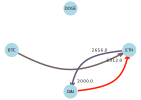

In [38]:
using Graphs, DataStructures
using GraphPlot
import ColorSchemes:diverging_linear_bjr_30_55_c53_n256

"""
    function gplot(orderbook::OrderBook, prices::Vector)

Plot the orderbook as a graph.

**Arguments**
* `orderbook`: The orderbook.
* `prices`: A vector of representing all the prices.
"""
function get_graph2(orderbook::OrderBook, prices::Vector; min_val=0, max_val=1000)
    g = SimpleDiGraph(length(orderbook.assets))
    cval = DefaultDict(0.)
    for order in orderbook.orders
        uv = order.buy ? (order.σ, order.β) : (order.β, order.σ)
        add_edge!(g, uv...)
        cval[uv...] = min(order.x̄ * prices[order.β], order.ȳ * prices[order.σ])
    end
    @show cval
    vvec = [cval[e.src, e.dst] for e in edges(g)]
    cvec = (vvec .- min_val) ./ (max_val - min_val)
    cc = get(diverging_linear_bjr_30_55_c53_n256, cvec)
    gplot(g; 
        layout=circular_layout, 
        nodefillc=colorant"lightblue", 
        edgestrokec = cc, 
        linetype="curve", 
        nodelabel=orderbook.assets,
        edgelabel=string.(round.(vvec; digits=2)),
        edgelabelc=cc,
    )
end
get_graph2(ob, prices; min_val=0, max_val=5000)


In [21]:
Int

LoadError: InexactError: Int64(1.2)

In [101]:
using Colors
G = Graph(8,12)
gplot(G; edgestrokec =rand(["red", "green", "blue"],12))

LoadError: MethodError: no method matching gplot(::SimpleGraph{Int64}; edgestrokec=["blue", "green", "blue", "green", "green", "blue", "green", "red", "red", "red", "blue", "red"])
[0mClosest candidates are:
[0m  gplot([91m::OrderBook[39m, [91m::Vector{T} where T[39m; min_val, max_val) at In[99]:12[91m got unsupported keyword argument "edgestrokec"[39m

In [18]:
using DataStructures

In [41]:
dd = DefaultDict(0)
dd[sort([1,2])...]


0

In [40]:
values(dd) .+ 1

1-element Vector{Int64}:
 1

In [61]:
dd[sort([1,2])...]
dd

DefaultDict{Any, Any, Int64} with 1 entry:
  (1, 2) => 0

In [47]:
dd = DefaultDict(0)

LoadError: UndefVarError: DefaultDict not defined

In [36]:
gplot(g, edgestrokec=cval)

LoadError: StackOverflowError:

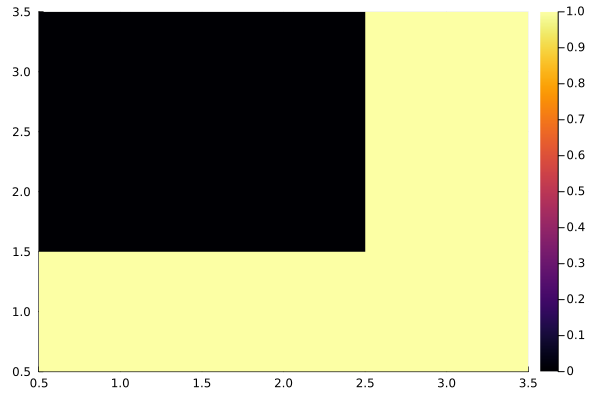

In [3]:
using Plots
g = [1 1 1;
     0 0 1;
     0 0 1]

res = heatmap(g, cmap=:inferno)

In [4]:
res?

LoadError: syntax: space required before "?" operator

In [15]:
import ColorSchemes.leonardo
c = get(leonardo, [0.1, 0.2])
typeof(c)

Vector{RGB{Float64}} (alias for Array{RGB{Float64}, 1})

In [8]:
ColorSchemes.leonardo

LoadError: UndefVarError: ColorSchemes not defined

In [18]:
using Graphs, Plots, GraphRecipes

g = [1 1 1;
     0 0 1;
     0 0 1]
cval = zeros(Float64, 3,3)
cval = zeros(Float64, 3,3)
# for 
# graphplot(DiGraph(g), self_edge_size=0.2, edgecolor=cmat)


3×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [20]:
A = adjacency_matrix(DiGraph(g))


3×3 SparseArrays.SparseMatrixCSC{Int64, Int64} with 5 stored entries:
 1  1  1
 ⋅  ⋅  1
 ⋅  ⋅  1

In [27]:
import SparseArrays.findnz
for (x,y,v) in zip(findnz(A)...)
    @show x, y, v
end

(x, y, v) = (1, 1, 1)
(x, y, v) = (1, 2, 1)
(x, y, v) = (1, 3, 1)
(x, y, v) = (2, 3, 1)
(x, y, v) = (3, 3, 1)


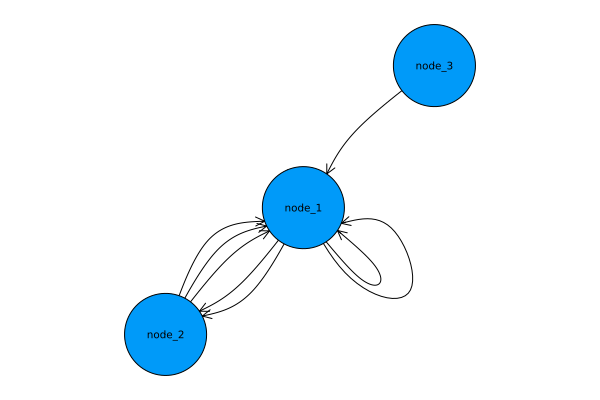

In [2]:
gplot(g, nodefillc=nodefillc, layout=circular_layout, edgestrokec=colors, edgelabel=1:78)